# *(Brette, et, al., 2007)* COBA

Implementation of the paper:

- Brette, R., Rudolph, M., Carnevale, T., Hines, M., Beeman, D., Bower, J. M., et al. (2007), Simulation of networks of spiking neurons: a review of tools and strategies., J. Comput. Neurosci., 23, 3, 349–98

which is based on the balanced network proposed by:

- Vogels, T. P. and Abbott, L. F. (2005), Signal propagation and logic gating in networks of integrate-and-fire neurons., J. Neurosci., 25, 46, 10786–95



Authors:

- [Chaoming Wang](https://github.com/chaoming0625)


In [1]:
import brainpy as bp

bp.math.set_platform('cpu')

In [2]:
class EINet(bp.Network):
  def __init__(self, scale=1.0, method='exp_auto'):
    # network size
    num_exc = int(3200 * scale)
    num_inh = int(800 * scale)

    # neurons
    pars = dict(V_rest=-60., V_th=-50., V_reset=-60., tau=20., tau_ref=5.)
    E = bp.models.LIF(num_exc, **pars, method=method)
    I = bp.models.LIF(num_inh, **pars, method=method)
    E.V[:] = bp.math.random.randn(num_exc) * 2 - 55.
    I.V[:] = bp.math.random.randn(num_inh) * 2 - 55.

    # synapses
    we = 0.6 / scale  # excitatory synaptic weight (voltage)
    wi = 6.7 / scale  # inhibitory synaptic weight
    E2E = bp.models.ExpCOBA(E, E, bp.conn.FixedProb(prob=0.02),
                            E=0., g_max=we, tau=5., method=method)
    E2I = bp.models.ExpCOBA(E, I, bp.conn.FixedProb(prob=0.02),
                            E=0., g_max=we, tau=5., method=method)
    I2E = bp.models.ExpCOBA(I, E, bp.conn.FixedProb(prob=0.02),
                            E=-80., g_max=wi, tau=10., method=method)
    I2I = bp.models.ExpCOBA(I, I, bp.conn.FixedProb(prob=0.02),
                            E=-80., g_max=wi, tau=10., method=method)

    super(EINet, self).__init__(E2E, E2I, I2E, I2I, E=E, I=I)

In [3]:
# network
net = EINet()

In [4]:
# simulation
runner = bp.StructRunner(net,
                         monitors=['E.spike'],
                         inputs=[('E.input', 20.), ('I.input', 20.)])
t = runner.run(100.)

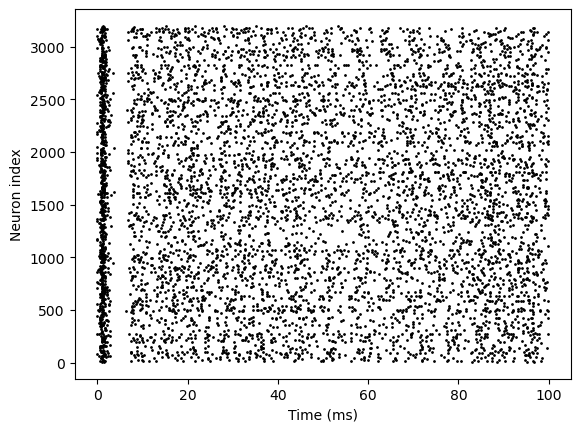

In [5]:
bp.visualize.raster_plot(runner.mon.ts, runner.mon['E.spike'], show=True)